<img style="float: left; padding-right: 0px; width: 145px" src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e9/EPF_logo_2021.png/524px-EPF_logo_2021.png"> 
<br><br>


###  <div style="text-align: right">  Data Engineering - P2024 <br> <br>  <time datetime="2023-12-16">2023/12/16 </time> <br> <br> <u>Name </u>: GAUBIL Clara </div>
<br> 



#   <center>  Time Series Analysis </center>


#  <center><u>  Final TSA report  : Airline Baggage Complaints </u></center>

The data set contains monthly observations from 2004 to 2010 for United Airlines, American Eagle, and Hawaiian Airlines. The variables in the data set include:

Baggage - The total number of passenger complaints for theft of baggage contents, or for lost, damaged, or misrouted luggage for the airline that month
Scheduled - The total number of flights scheduled by that airline that month
Cancelled - The total number of flights cancelled by that airline that month
Enplaned - The total number of passengers who boarded a plane with the airline that month

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                
import seaborn as sns  

## **1- Data exploration and cleaning**

In [15]:
# open the csv file
path = 'baggagecomplaints.csv'
df_baggage = pd.read_csv(path)

In [16]:
df_baggage.head(15)

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,01/2004,1,2004,12502,38276,2481,992360
1,American Eagle,02/2004,2,2004,8977,35762,886,1060618
2,American Eagle,03/2004,3,2004,10289,39445,1346,1227469
3,American Eagle,04/2004,4,2004,8095,38982,755,1234451
4,American Eagle,05/2004,5,2004,10618,40422,2206,1267581
5,American Eagle,06/2004,6,2004,13684,39879,1580,1347303
6,American Eagle,07/2004,7,2004,14121,41586,1819,1396642
7,American Eagle,08/2004,8,2004,12732,42016,1465,1339264
8,American Eagle,09/2004,9,2004,7895,40871,1077,1292147
9,American Eagle,10/2004,10,2004,9444,42381,1090,1393881


In [17]:
df_baggage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Airline    252 non-null    object
 1   Date       252 non-null    object
 2   Month      252 non-null    int64 
 3   Year       252 non-null    int64 
 4   Baggage    252 non-null    int64 
 5   Scheduled  252 non-null    int64 
 6   Cancelled  252 non-null    int64 
 7   Enplaned   252 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.9+ KB


In [24]:
df_baggage['Date'] = pd.to_datetime(df_baggage['Date'])

In [18]:
df_baggage.describe()

,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
count,252.000000,252.00000,252.000000,252.000000,252.000000,2.520000e+02
mean,6.500000,2007.00000,12613.507937,28128.007937,703.761905,2.203871e+06
std,3.458922,2.00398,9993.307166,17092.087874,746.020368,1.788200e+06
min,1.000000,2004.00000,1033.000000,3553.000000,0.000000,4.234460e+05
25%,3.750000,2005.00000,1910.500000,5565.750000,25.750000,6.865205e+05
50%,6.500000,2007.00000,12224.000000,36696.000000,533.000000,1.391112e+06
75%,9.250000,2009.00000,19359.250000,42162.500000,1078.500000,4.111049e+06
max,12.000000,2010.00000,41787.000000,50837.000000,3712.000000,6.137271e+06


We need to modifiy the date column to have it in a more usable format:

In [19]:
df_baggage['Airline'].value_counts()

Airline
American Eagle    84
Hawaiian          84
United            84
Name: count, dtype: int64

Each airline has 84 observations, there are no duplicates in dataset or missing values.

## **2- Saisonality:**

In this part we will try to see wheter there is some saisonality in the data or not.

### 2_1: first (visual) analysis

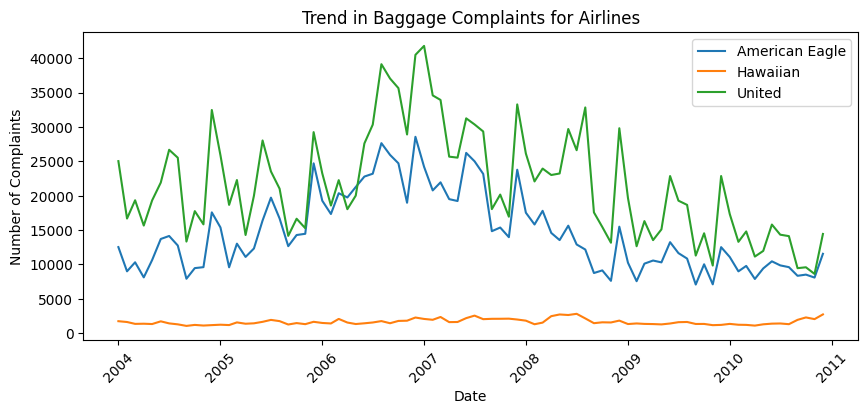

In [25]:
plt.figure(figsize=(10, 4))

sns.lineplot(x='Date', y='Baggage', hue='Airline', data=df_baggage)

plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Trend in Baggage Complaints for Airlines')

plt.xticks(rotation=45)
plt.legend()
plt.show()


It seems that ther is some seasonality in the data of the american airline and the United airline but not on the Hawaiian airline. To be sure of thatt, we will conduce a time series decomposition and then a fisher test. But first, let's see if the model decomposition if additive or multiplicative. By first analysis the above plot, we can say that the model seems additive since the amplitude of the seasonal fluctuations appears relatively constant over time for the American Eagle airline and the United airline.

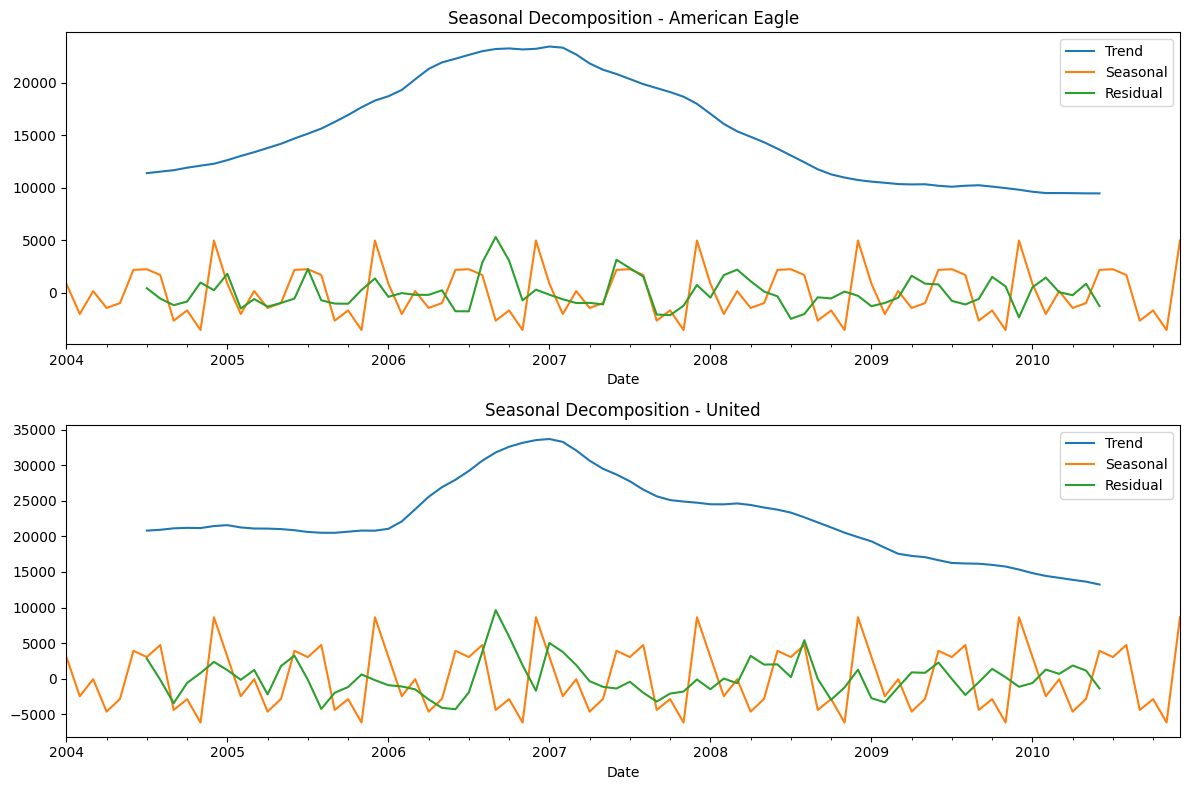

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'Date' column is not in datetime format
df_baggage['Date'] = pd.to_datetime(df_baggage['Date'])

# Set 'Date' column as the index
df_baggage.set_index('Date', inplace=True)

# Decompose the time series for American Eagle
result_ae = seasonal_decompose(df_baggage[df_baggage['Airline'] == 'American Eagle']['Baggage'], model='additive', period=12)

# Decompose the time series for United
result_united = seasonal_decompose(df_baggage[df_baggage['Airline'] == 'United']['Baggage'], model='additive', period=12)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.title('Seasonal Decomposition - American Eagle')
result_ae.trend.plot(label='Trend')
result_ae.seasonal.plot(label='Seasonal')
result_ae.resid.plot(label='Residual')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Seasonal Decomposition - United')
result_united.trend.plot(label='Trend')
result_united.seasonal.plot(label='Seasonal')
result_united.resid.plot(label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
from statsmodels.stats.libqsturng import qsturng
from statsmodels.stats import anova

# Perform Fisher test
_, pvalue = anova.fisher_test(result_ae.resid, result_united.seasonal)

# Significance level (e.g., 0.05)
alpha = 0.05

# Compare p-value to significance level
if pvalue < alpha:
    print("Reject the null hypothesis: Seasonality is present.")
else:
    print("Fail to reject the null hypothesis: Seasonality is not significant.")


AttributeError: module 'statsmodels.stats.anova' has no attribute 'fisher_test'

In [28]:
from scipy.stats import f_oneway

# Extract the seasonal component for American Eagle and United
seasonal_ae = result_ae.seasonal.dropna()
seasonal_united = result_united.seasonal.dropna()

# Perform Fisher test for seasonality
f_stat, p_value = f_oneway(seasonal_ae, seasonal_united)

print(f'Fisher Statistic: {f_stat}')
print(f'P-value: {p_value}')

# Check the p-value
if p_value < 0.05:
    print('Reject the null hypothesis: Seasonality is present')
else:
    print('Fail to reject the null hypothesis: Seasonality is not confirmed')


Fisher Statistic: 5.450277011344869e-33
P-value: 1.0
Fail to reject the null hypothesis: Seasonality is not confirmed
